# Data Description

# Import Libraries

In [1]:
#original libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
import seaborn as sns
from PIL import Image
import time
from tqdm.notebook import tqdm
import os

#opencv libraries
import cv2

#pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim

In [2]:
#file extensions editting
#print(os.listdir("../input"))
base_dir = "../input/aptos2019-blindness-detection/"

# Data Loading & Exploratory Data Analysis

In [3]:
train_csv = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
test_csv = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")

train_path = "../input/aptos2019-blindness-detection/train_images/"
test_path = "../input/aptos2019-blindness-detection/test_images/"

print("Training Data Size: {}".format(len(train_csv)))
print("Testing Data Size: {}".format(len(test_csv)))

Training Data Size: 3662
Testing Data Size: 1928


In [4]:
train_csv.head()
#test_csv.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


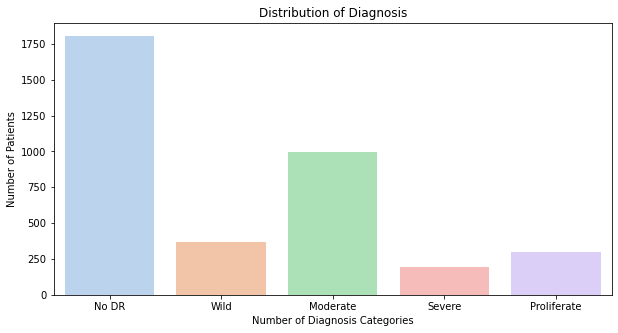

In [5]:
#EDA: Draw graph to examine the distribution of each dianosis
diag_num = train_csv['diagnosis'].value_counts()
diag_list = ['No DR','Wild','Moderate','Severe','Proliferate']
for u,v in enumerate(diag_list):
    diag_num[v] = diag_num.pop(u)
    
plt.figure(figsize=(10,5))
sns.barplot(diag_num.index, diag_num.values, alpha=0.8, palette='pastel')
plt.title("Distribution of Diagnosis")
plt.ylabel("Number of Patients")
plt.xlabel("Number of Diagnosis Categories")
plt.show()

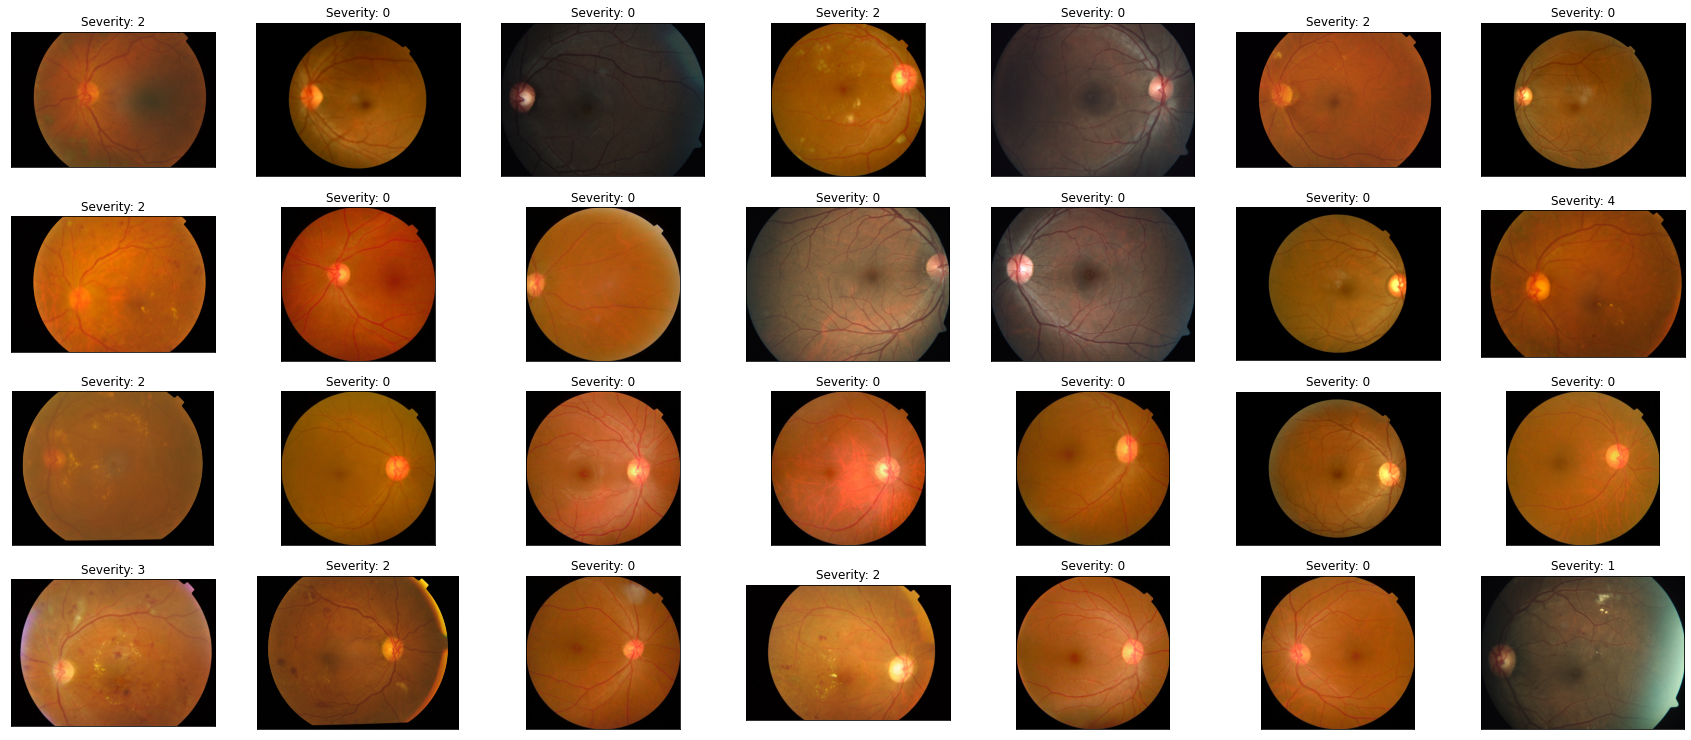

In [6]:
fig1 = plt.figure(figsize=(30,13))
train_img = os.listdir(base_dir+"/train_images")
for idx,img in enumerate(np.random.choice(train_img, 28)):
    axe = fig1.add_subplot(4, 28//4, idx+1, xticks=[], yticks=[])
    _img = Image.open(base_dir+"/train_images/"+img)
    plt.imshow(_img)
    cate = train_csv.loc[train_csv['id_code'] == img.split('.')[0],'diagnosis'].values[0] #access a group of rows and columns by label(s) 
    axe.set_title('Severity: %s'%cate)

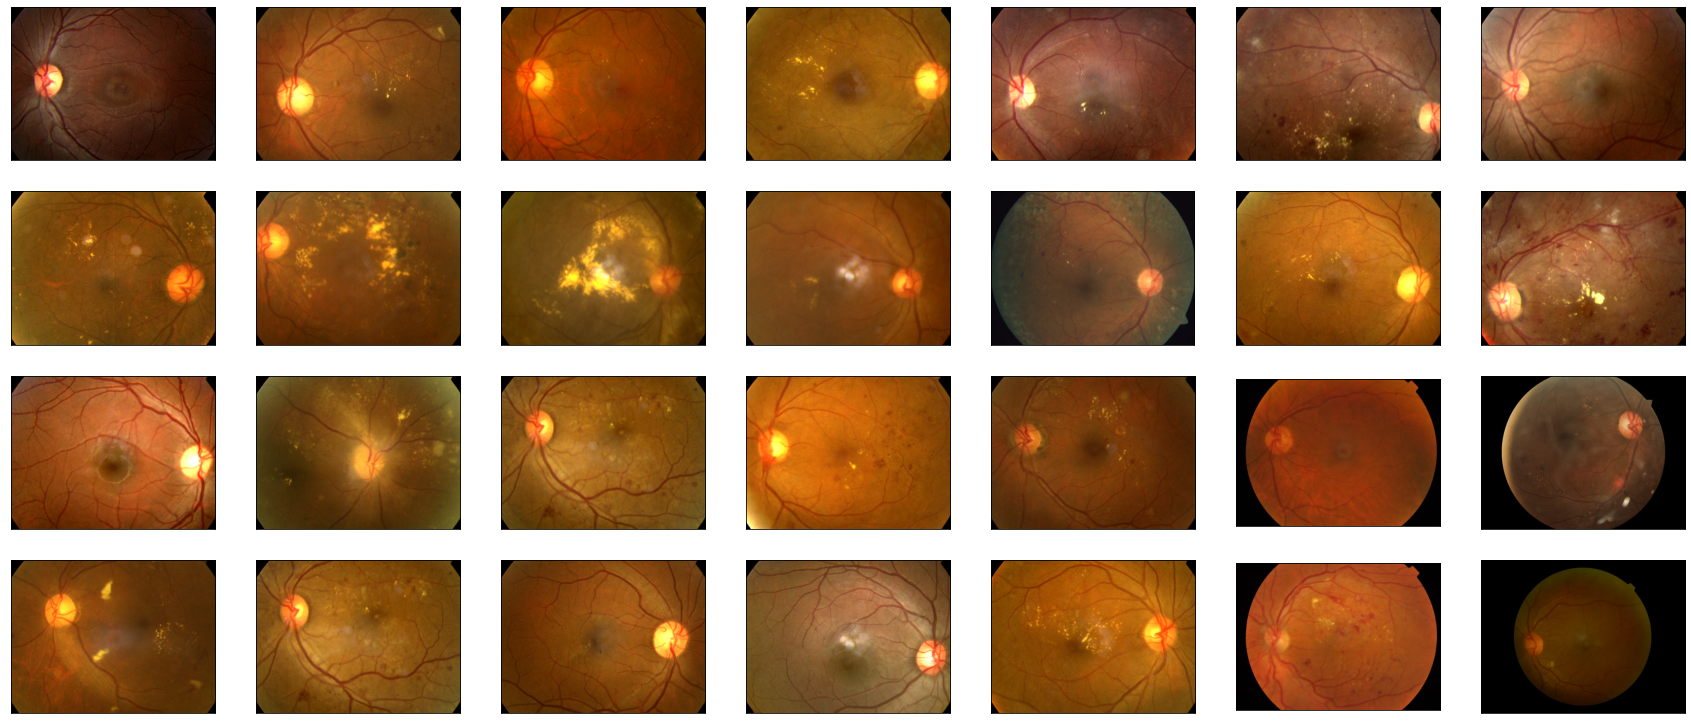

In [7]:
fig2 = plt.figure(figsize=(30,13))
test_img = os.listdir(base_dir+"/test_images")
for idx,img in enumerate(np.random.choice(test_img, 28)):
    axe = fig2.add_subplot(4, 28//4, idx+1, xticks=[], yticks=[])
    _img = Image.open(base_dir+"/test_images/"+img)
    plt.imshow(_img)

# Data Processing

In [8]:
class DataProcessing(Dataset):
    def __init__(self, df_data, data_dir='../input/', transform=None):
        super().__init__()
        self.df = df_data.values #return a Numpy representation of the DataFrame, the axes labels will be removed
        self.data_dir = data_dir
        self.transform = transform #return a self-produced dataframe with transformed values after applying the function specified in its parameter
        
    def __len__(self):
        return len(self.df)
    
    def get_item(self,idx):
        img_name,label = self.df[idx]
        img_path = os.path.join(self.data_dir, img_name+'.jpg')
        img = cv2.imread(img_path)
        if(self.transform is not None):
            img = self.transform(img)
        return img, label

In [9]:
transforms = transforms.Compose([transforms.ToPILImage(), transforms.Resize((256,256)), transforms.RandomHorizontalFlip(p=0.4), transforms.ToTensor(), transforms.Normalize(mean=(0.485,0.456,0.406),std=(0.229,0.224,0.225))])

In [10]:
train_data = DataProcessing(df_data=train_csv, data_dir=train_path, transform=transforms)

In [11]:
#divide training and validation data
batch_size = 16
valid_size = 0.2
train_num = len(train_data)
index = list(range(train_num))
split = int(np.floor(valid_size*train_num))
train_index,valid_index = index[split:],index[split:]

#create samplers
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

#data loader
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

# Model

In [12]:
model = models.resnet50(pretrained=False)
model.load_state_dict(torch.load('../input/pretrainedmodels/resnet50-19c8e357.pth'))
model.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
model.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=1024, bias=True),nn.Linear(in_features=1024, out_features=1, bias=True))

In [13]:
#check CUDA available
GPU_train = torch.cuda.is_available()

if(GPU_train):
    print('Train on GPU!')
    model.cuda()
else:
    print('Train on CPU! CUDA is not available')

Train on CPU! CUDA is not available


# Fine Tuning

In [16]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#device = torch.device('cuda' if torch.cuda.is_available() else 'CPU')

In [17]:
epochs = 20
valoss_min = 1e4

train_loss_list = []
valid_loss_list = []
val_kappa = []
test_accuracy_list = []
valid_accuracy_list = []
kappa_epoch = []
batch = 0

for epoch in range(1,epochs+1):
    train_loss = 0
    valid_loss = 0
    model.train()
    
    for feature,target in tqdm.notebook.tqdm(train_loader):
        #move tensors to GPU if CUDA available
        if(GPU_train):
            feature,target = feature.cuda(), target.cuda().float()
        target = target.view(-1,1)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            output = model(feature)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
        train_loss += loss.item()*feature.size(0)
    model.eval()
            
    for feature,target in tqdm_notebook(valid_loader):
        #move tensors to GPU if CUDA available
        if(GPU_train):
            feature,target = feature.cuda(), target.cuda().float()
        target = target.view(-1,1)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            output = model(feature)
            loss = criterion(output,target)
        valid_loss += loss.item()*feature.size(0)
        y_act = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_kappa.append(cohen_kappa_score(y_act,y_pred.round()))
    
    train_loss /= len(train_loader.sampler)
    valid_loss /= len(valid_loader.sampler)
    valid_kappa = np.mean(val_kappa)
    kappa_epoch.append(np.mean(val_kappa))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    print('Epoch: {}. Training Loss: {:.4f}. Var Loss: {:.4f}. Var Kap: {:.4f}'.format(epoch,train_loss,valid_loss,valid_kappa))
    
    if(valid_loss<=valoss_min):
        print('Saving Model Checkpoint...')
        torch.save(model.state_dict(),'model_checkpoint.pt')
        valoss_min = valid_loss

AttributeError: type object 'tqdm_notebook' has no attribute 'notebook'

# Test Inference

In [21]:
test_transforms = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), torchvision.transforms.Resize((224, 224)), torchvision.transforms.RandomHorizontalFlip(p=0.5), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
test_csv['diagnosis'] = -1

In [23]:
test_data = DataProcessing(df_data=test_csv, data_dir=test_path, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [24]:
def prediction_round(preds):
    for i,pred in enumerate(preds):
            if(pred<0.5):
                preds[i] = 0
            elif(pred>=0.5 and pred<1.5):
                preds[i] = 1
            elif(pred>=1.5 and pred<2.5):
                preds[i] = 2
            elif(pred>=2.5 and pred<3.5):
                preds[i] = 3
            else:
                preds[i] = 4
    return preds

In [25]:
def prediction(test_loader):
    model.eval()
    preds = []
    for _batch,(feature,target) in enumerate(test_loader):
        feature,target = feature.cuda(),target.cuda()
        output = model(feature)
        _prediction = output.detach().cpu().numpy()
        for i in _prediction:
            preds.append(i.item())
    return preds

# Prediction Submission

In [ ]:
submission = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

submission.diagnosis = preds
submission.diagnosis = submission['diagnosis'].astype(int64)

#submission.head()

submission.to_csv('submission.csv', index=False)